<a href="https://colab.research.google.com/github/Kishorecit/Data-Science/blob/main/housing_price_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import all the necessary python packages:

In [ ]:
import pandas as pd
import numpy as np
import math
from math import sqrt
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_theme(style="darkgrid")

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn import neighbors
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.model_selection import cross_val_score

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.datasets import make_regression
from sklearn.svm import SVR
from sklearn.datasets import make_regression
from sklearn import tree
import xgboost as xgb

In [ ]:
data=pd.read_csv('Chennai houseing sale.csv')
pd.set_option('display.max_columns',None)
data.head(3)

,PRT_ID,AREA,INT_SQFT,DATE_SALE,DIST_MAINROAD,N_BEDROOM,N_BATHROOM,N_ROOM,SALE_COND,PARK_FACIL,DATE_BUILD,BUILDTYPE,UTILITY_AVAIL,STREET,MZZONE,QS_ROOMS,QS_BATHROOM,QS_BEDROOM,QS_OVERALL,REG_FEE,COMMIS,SALES_PRICE
0,P03210,Karapakkam,1004,04-05-2011,131,1.0,1.0,3,AbNormal,Yes,15-05-1967,Commercial,AllPub,Paved,A,4.0,3.9,4.9,4.330,380000,144400,7600000
1,P09411,Anna Nagar,1986,19-12-2006,26,2.0,1.0,5,AbNormal,No,22-12-1995,Commercial,AllPub,Gravel,RH,4.9,4.2,2.5,3.765,760122,304049,21717770
2,P01812,Adyar,909,04-02-2012,70,1.0,1.0,3,AbNormal,Yes,09-02-1992,Commercial,ELO,Gravel,RL,4.1,3.8,2.2,3.090,421094,92114,13159200


Data Cleaning

In [ ]:
data.dropna(inplace=True)

data.columns = data.columns.str.lower()

data.area = data.area.str.lower()

data.area = data.area.replace({'velchery':'velachery',
                       'kknagar':'kk nagar',
                       'tnagar':'t nagar',
                       'chormpet':'chrompet',
                       'chrompt':'chrompet',
                       'chrmpet':'chrompet',
                       'ana nagar':'anna nagar',
                       'ann nagar':'anna nagar',
                       'karapakam':'karapakkam',
                       'adyr':'adyar'})

data.sale_cond = data.sale_cond.str.lower()

data.sale_cond = data.sale_cond.replace({'adj land':'adjland',
                       'normal sale':'normal sale',
                       'partiall':'partial',
                       'ab normal':'abnormal'})

data.park_facil = data.park_facil.str.lower()

data.park_facil = data.park_facil.replace({'noo':'no'})

data.buildtype = data.buildtype.str.lower()

data.buildtype = data.buildtype.replace({'comercial':'commercial',
                       'others':'other'})

data.utility_avail = data.utility_avail.str.lower()

data.utility_avail = data.utility_avail.replace({'all pub':'allpub',
                                             'nosewr':'nosewa'})



In [ ]:
data.street = data.street.str.lower()

data.street = data.street.replace({'pavd':'paved',
                       'noaccess':'no access'})

data.mzzone = data.mzzone.str.lower()

data.n_bedroom = data.n_bedroom.astype(int)
data.n_bathroom = data.n_bathroom.astype(int)

data.date_sale = pd.to_datetime(data.date_sale, format='%d-%m-%Y')
data.date_build = pd.to_datetime(data.date_build, format='%d-%m-%Y')

data['property_age'] = pd.DatetimeIndex(data.date_sale).year - pd.DatetimeIndex(data.date_build).year

data['total_price'] = pd.DataFrame(data.reg_fee	+ data.commis	+ data.sales_price)

data = data.reindex(columns = ['prt_id', 'area', 'sale_cond', 'park_facil',
       'buildtype', 'utility_avail', 'street', 'mzzone',
       'date_build', 'date_sale', 'property_age',
       'int_sqft', 'dist_mainroad', 'n_bedroom','n_bathroom', 'n_room',
       'qs_rooms', 'qs_bathroom', 'qs_bedroom', 'qs_overall',
       'reg_fee', 'commis', 'sales_price', 'total_price'])

data.head()

,prt_id,area,sale_cond,park_facil,buildtype,utility_avail,street,mzzone,date_build,date_sale,property_age,int_sqft,dist_mainroad,n_bedroom,n_bathroom,n_room,qs_rooms,qs_bathroom,qs_bedroom,qs_overall,reg_fee,commis,sales_price,total_price
0,P03210,karapakkam,abnormal,yes,commercial,allpub,paved,a,1967-05-15,2011-05-04,44,1004,131,1,1,3,4.0,3.9,4.9,4.330,380000,144400,7600000,8124400
1,P09411,anna nagar,abnormal,no,commercial,allpub,gravel,rh,1995-12-22,2006-12-19,11,1986,26,2,1,5,4.9,4.2,2.5,3.765,760122,304049,21717770,22781941
2,P01812,adyar,abnormal,yes,commercial,elo,gravel,rl,1992-02-09,2012-02-04,20,909,70,1,1,3,4.1,3.8,2.2,3.090,421094,92114,13159200,13672408
3,P05346,velachery,family,no,other,nosewr,paved,i,1988-03-18,2010-03-13,22,1855,14,3,2,5,4.7,3.9,3.6,4.010,356321,77042,9630290,10063653
4,P06210,karapakkam,abnormal,yes,other,allpub,gravel,c,1979-10-13,2009-10-05,30,1226,84,1,1,3,3.0,2.5,4.1,3.290,237000,74063,7406250,7717313


Exploratory Data Analysis

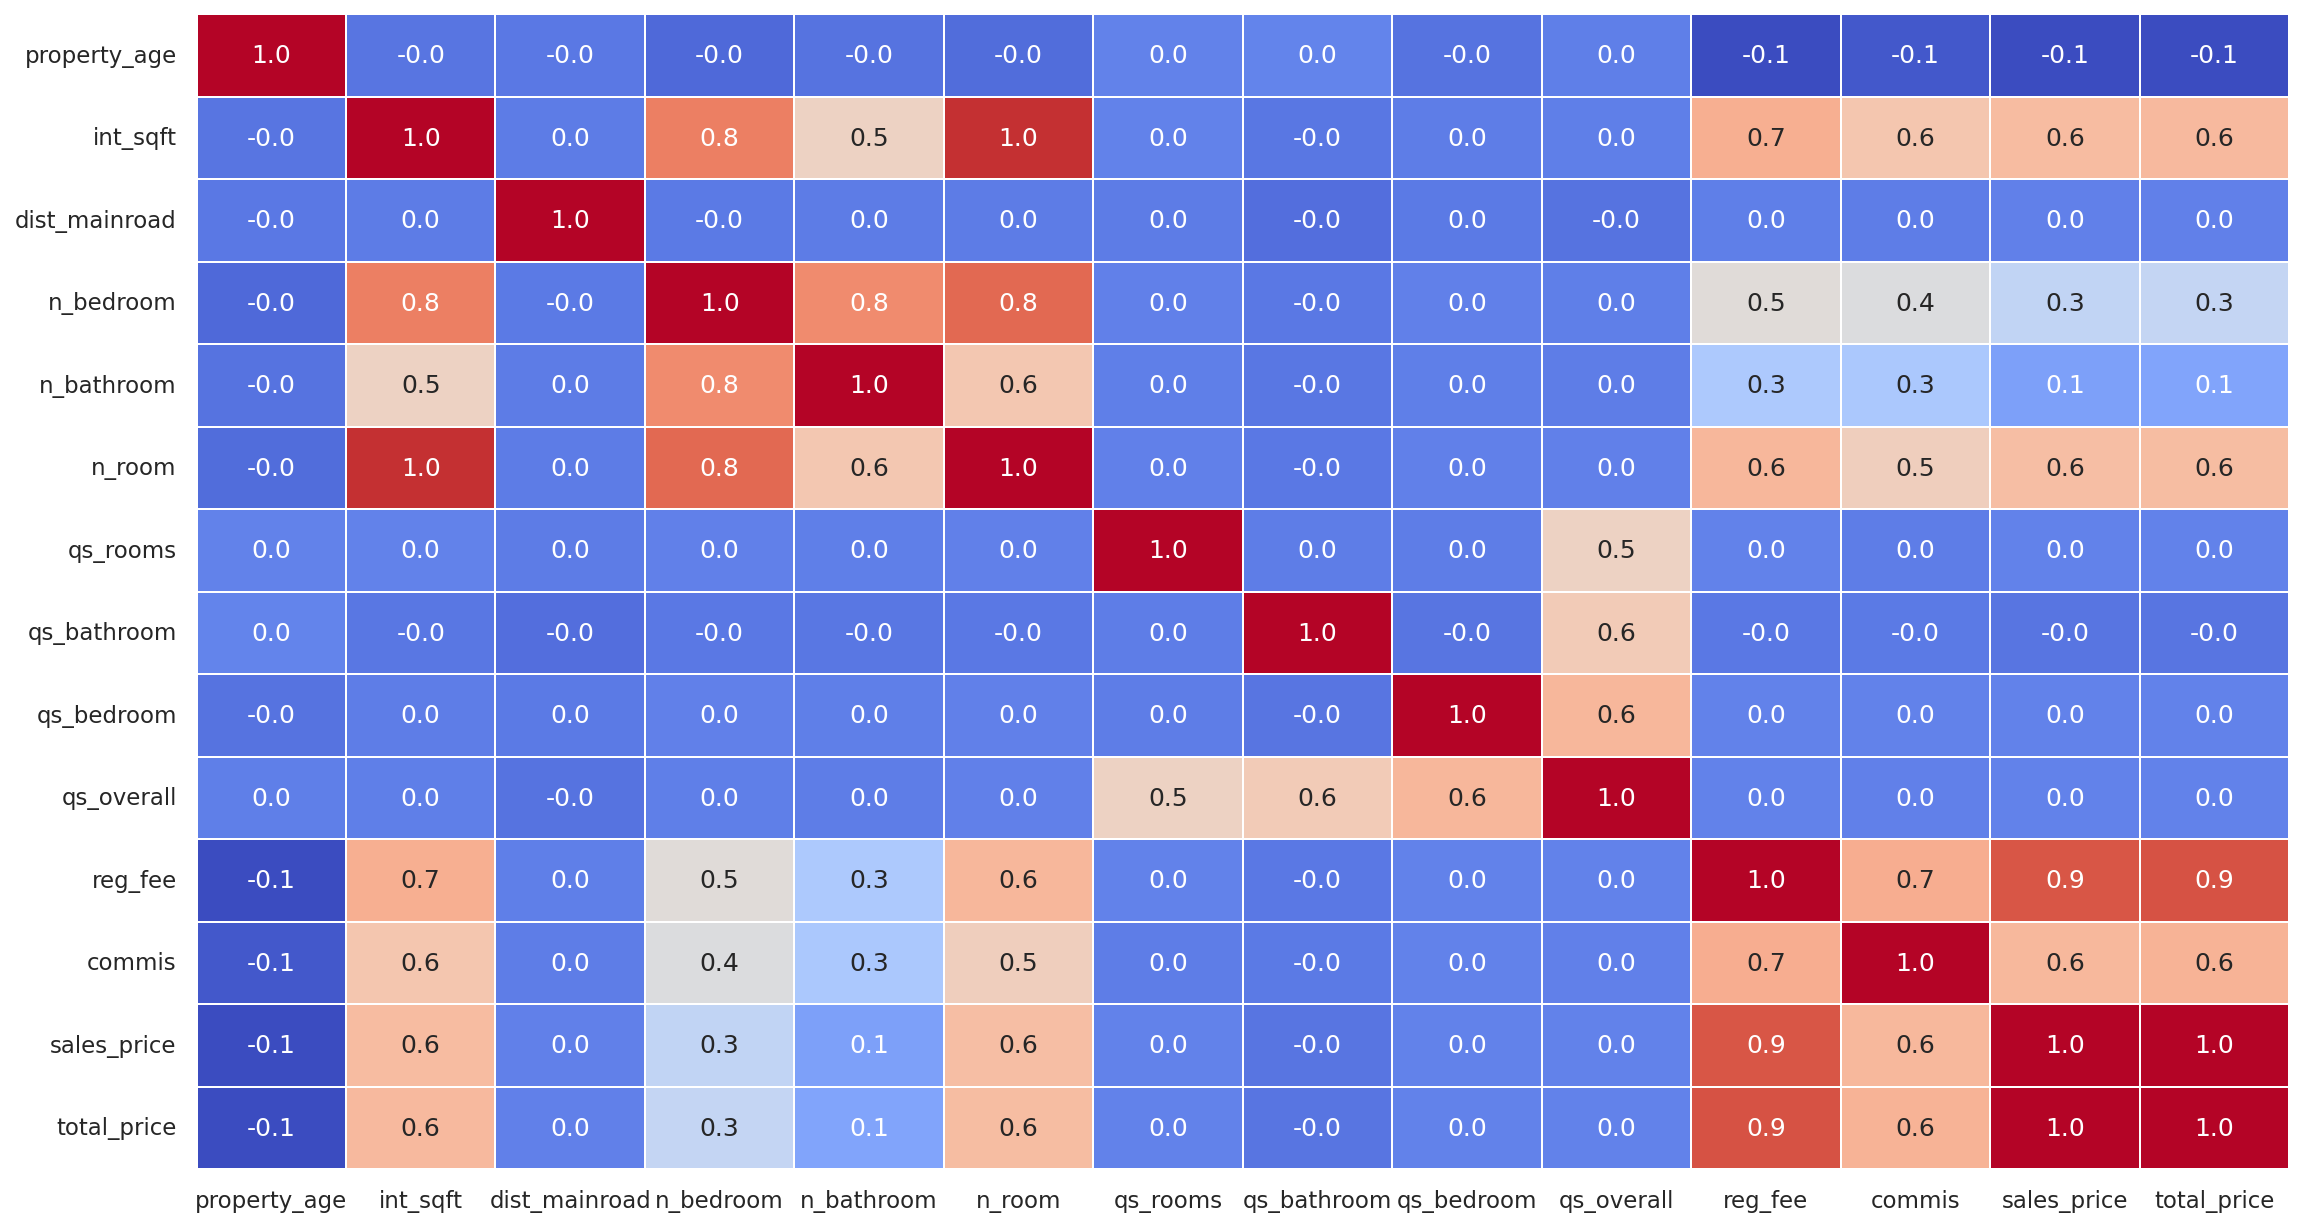

In [ ]:
plt.figure(figsize=(18,10), dpi=150)
sns.heatmap(data.corr(method='pearson'), cbar=False, annot=True, fmt='.1f', linewidth=0.2, cmap='coolwarm');

Distribution Of Features in Data Columns

In [ ]:
plt.figure(figsize=(150, 150), dpi=200)

plt.subplot(5,4,1)
sns.histplot(data.area, linewidth=0,kde=True)

plt.subplot(5,4,2)
sns.histplot(data.sale_cond, linewidth=0,kde=True)

plt.subplot(5,4,3)
sns.histplot(data.park_facil, linewidth=0,kde=True)

plt.subplot(5,4,4)
sns.histplot(data.buildtype, linewidth=0,kde=True)

<Axes: xlabel='buildtype', ylabel='Count'>

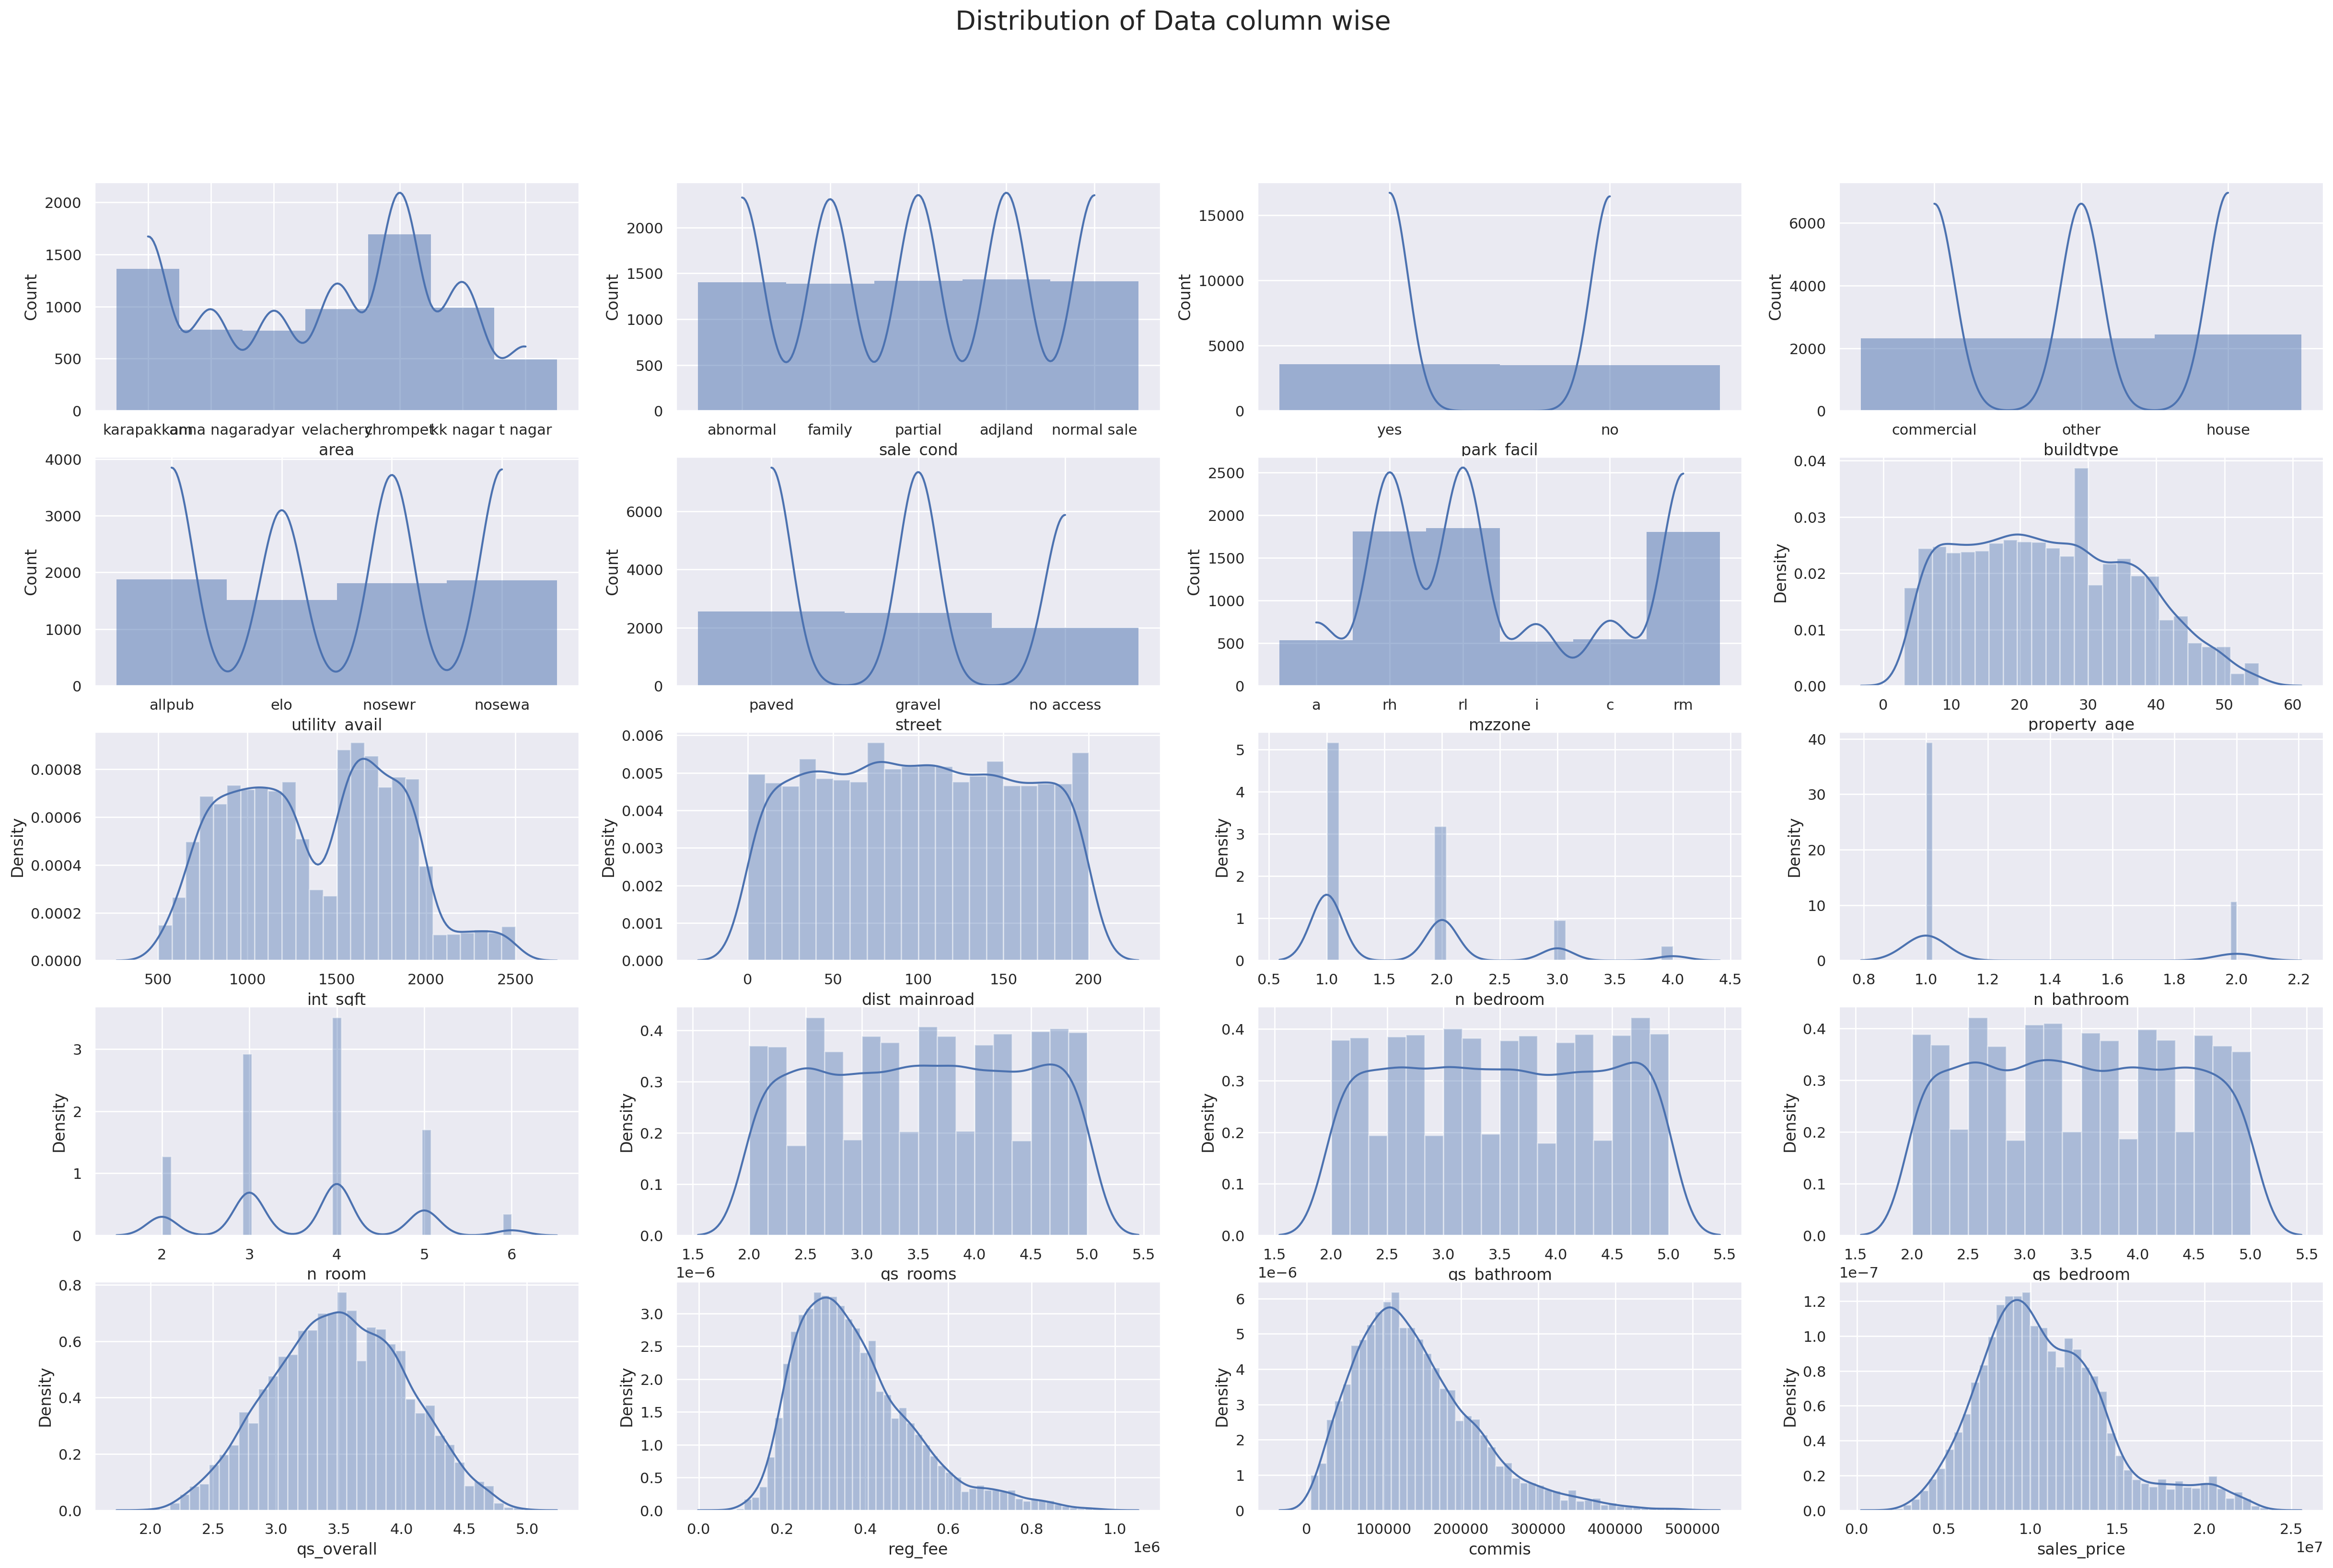

In [ ]:
plt.figure(figsize=(30, 18), dpi=200)

plt.subplot(5,4,1)
sns.histplot(data.area, linewidth=0,kde=True)

plt.subplot(5,4,2)
sns.histplot(data.sale_cond, linewidth=0,kde=True)

plt.subplot(5,4,3)
sns.histplot(data.park_facil, linewidth=0,kde=True)

plt.subplot(5,4,4)
sns.histplot(data.buildtype, linewidth=0,kde=True)

plt.subplot(5,4,5)
sns.histplot(data.utility_avail, linewidth=0,kde=True)

plt.subplot(5,4,6)
sns.histplot(data.street, linewidth=0,kde=True)

plt.subplot(5,4,7)
sns.histplot(data.mzzone, linewidth=0,kde=True)

plt.subplot(5,4,8)
sns.distplot(data.property_age)

plt.subplot(5,4,9)
sns.distplot(data.int_sqft)

plt.subplot(5,4,10)
sns.distplot(data.dist_mainroad)

plt.subplot(5,4,11)
sns.distplot(data.n_bedroom)

plt.subplot(5,4,12)
sns.distplot(data.n_bathroom)

plt.subplot(5,4,13)
sns.distplot(data.n_room)

plt.subplot(5,4,14)
sns.distplot(data.qs_rooms)

plt.subplot(5,4,15)
sns.distplot(data.qs_bathroom)

plt.subplot(5,4,16)
sns.distplot(data.qs_bedroom)

plt.subplot(5,4,17)
sns.distplot(data.qs_overall)

plt.subplot(5,4,18)
sns.distplot(data.reg_fee)

plt.subplot(5,4,19)
sns.distplot(data.commis)

plt.subplot(5,4,20)
sns.distplot(data.sales_price)

plt.suptitle("Distribution of Data column wise", fontsize=20)
plt.show()

Categorical Columns

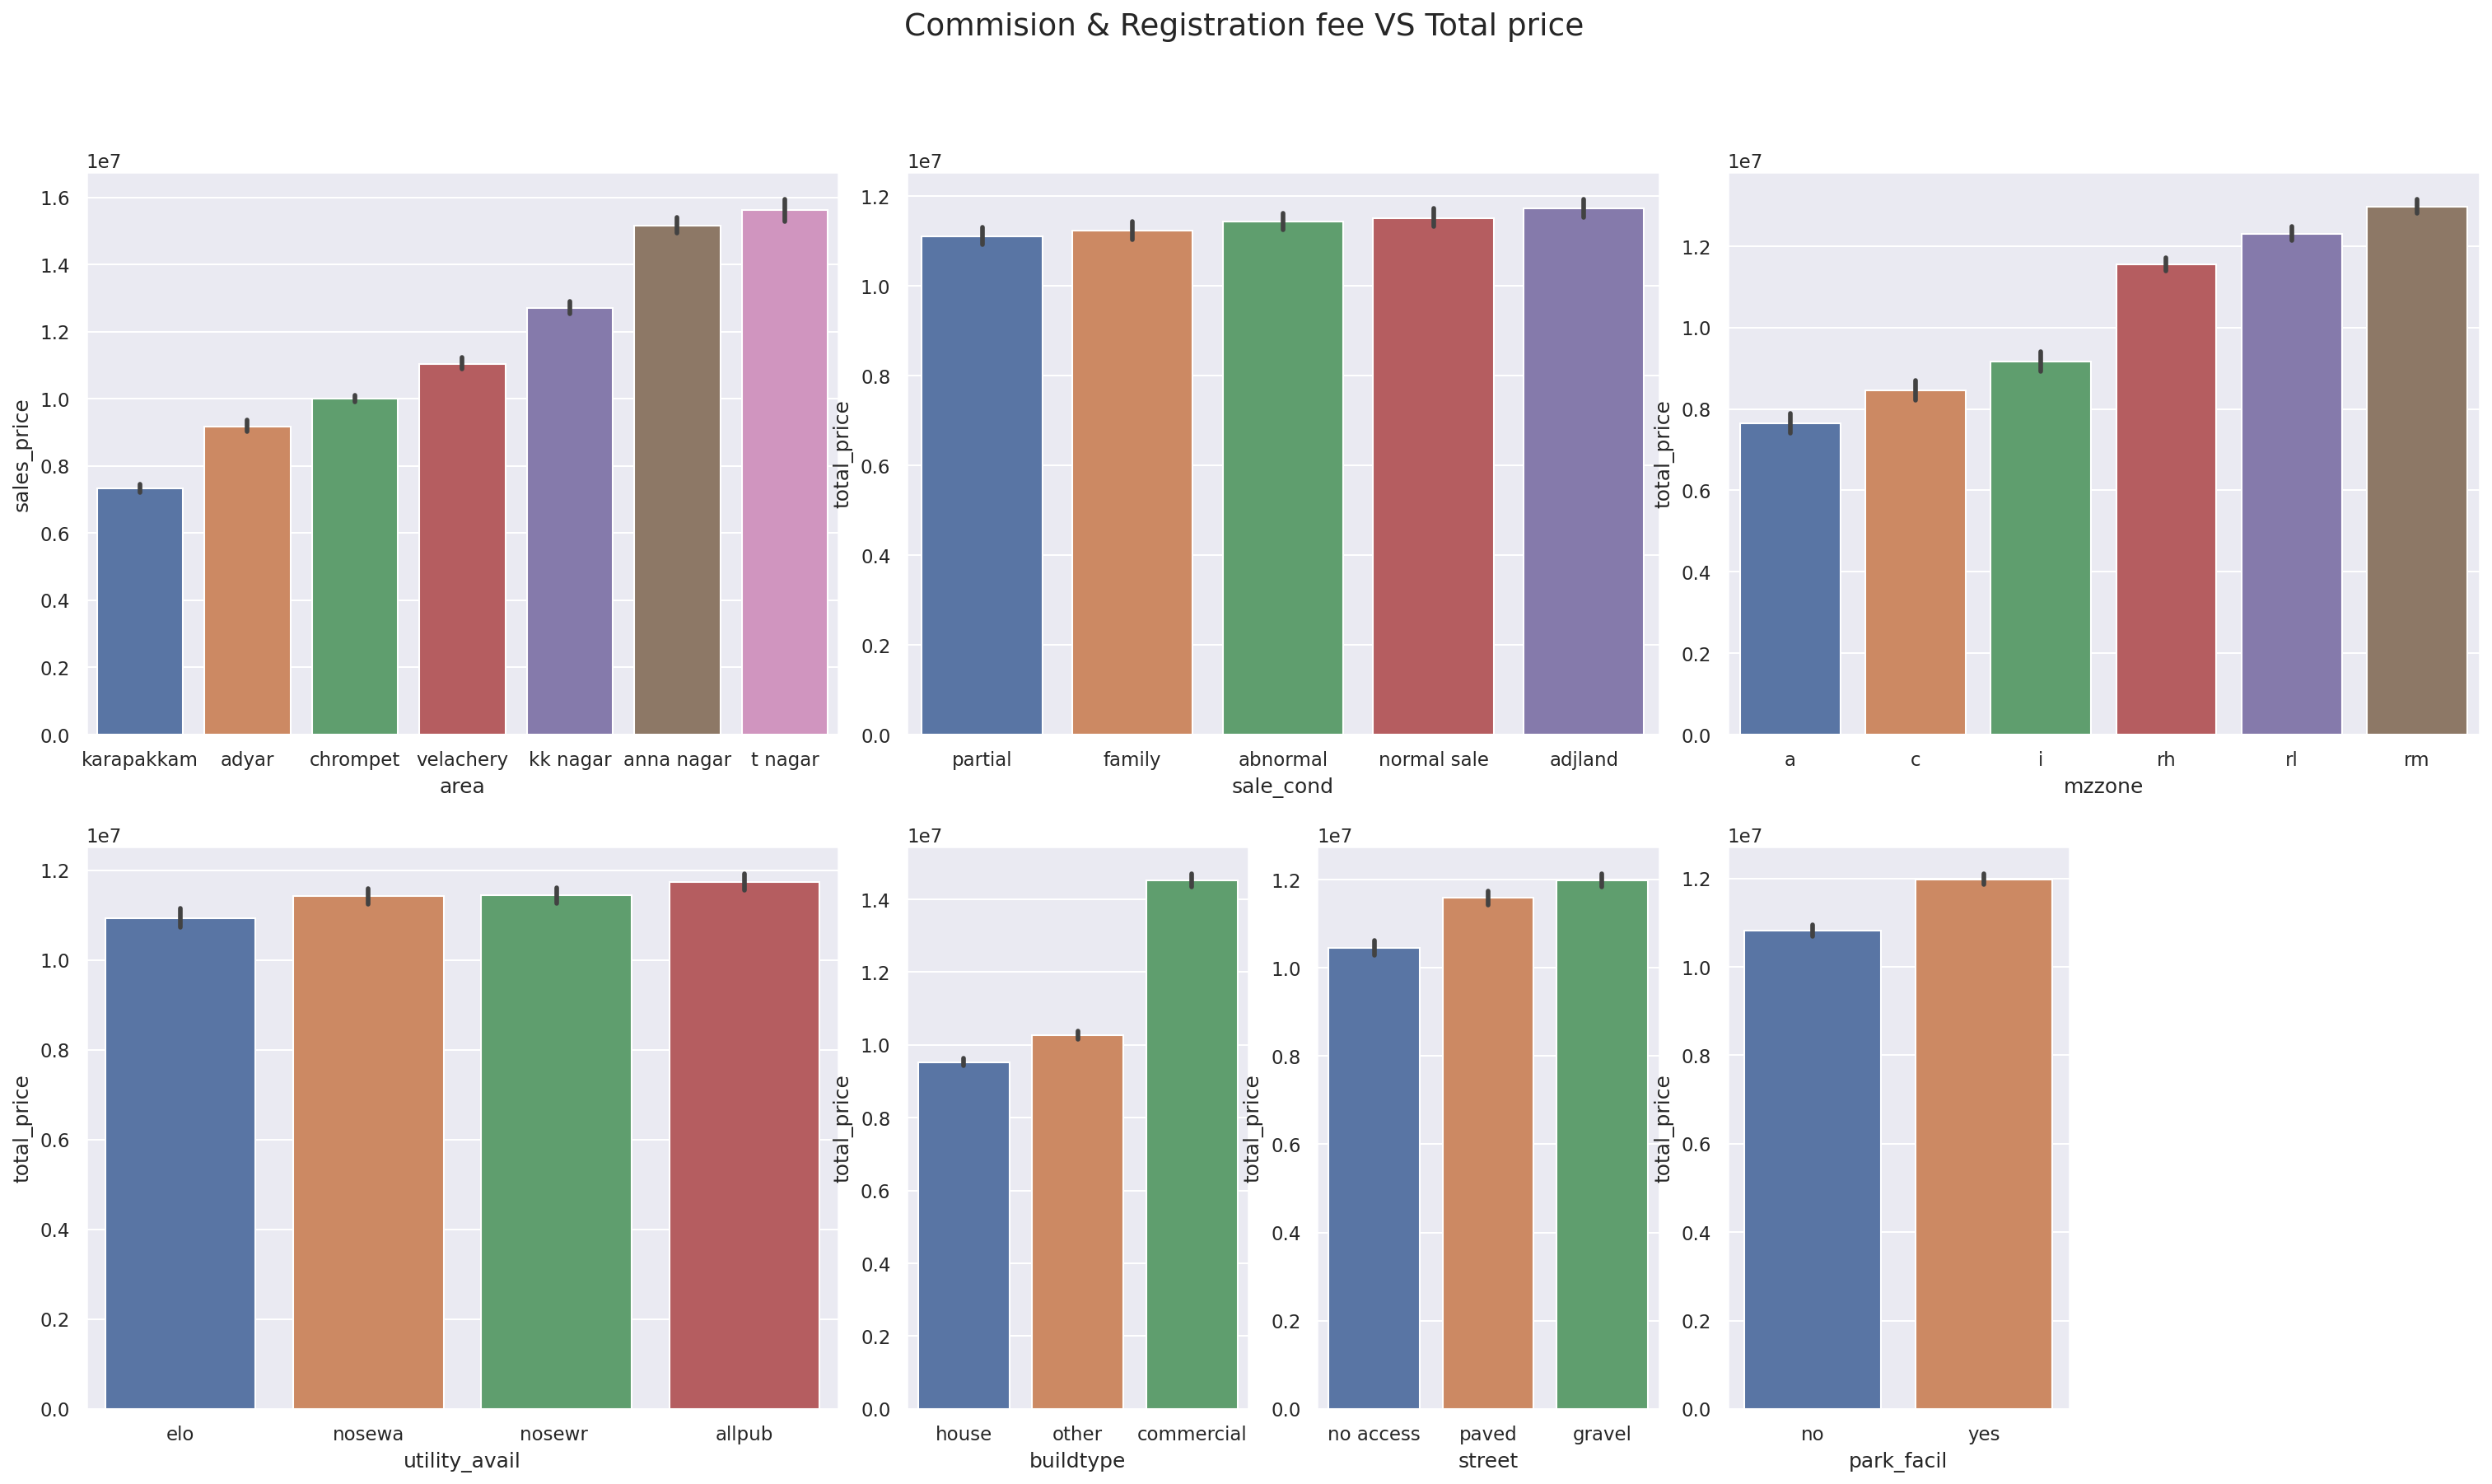

In [ ]:
plt.figure(figsize=(25, 13), dpi=150)

plt.subplot2grid((2,6),(0,0),colspan=2)
sns.barplot(x=data.area,y=data.sales_price,order=data.groupby('area')['sales_price'].mean().reset_index().sort_values('sales_price')['area'])

plt.subplot2grid((2,6),(0,2),colspan=2)
sns.barplot(x=data.sale_cond,y=data.total_price,order=data.groupby('sale_cond')['total_price'].mean().reset_index().sort_values('total_price')['sale_cond'])

plt.subplot2grid((2,6),(0,4),colspan=2)
sns.barplot(x=data.mzzone,y=data.total_price,order=data.groupby('mzzone')['total_price'].mean().reset_index().sort_values('total_price')['mzzone'])

plt.subplot2grid((2,6),(1,0),colspan=2)
sns.barplot(x=data.utility_avail,y=data.total_price,order=data.groupby('utility_avail')['total_price'].mean().reset_index().sort_values('total_price')['utility_avail'])

plt.subplot2grid((2,6),(1,2))
sns.barplot(x=data.buildtype,y=data.total_price,order=data.groupby('buildtype')['total_price'].mean().reset_index().sort_values('total_price')['buildtype'])

plt.subplot2grid((2,6),(1,3))
sns.barplot(x=data.street,y=data.total_price,order=data.groupby('street')['total_price'].mean().reset_index().sort_values('total_price')['street'])

plt.subplot2grid((2,6),(1,4))
sns.barplot(x=data.park_facil,y=data.total_price,order=data.groupby('park_facil')['total_price'].mean().reset_index().sort_values('total_price')['park_facil'])

plt.suptitle("Commision & Registration fee VS Total price", fontsize=18)
plt.show()

OneHotEncoder

In [ ]:
data = pd.get_dummies(data,columns=['buildtype'])

Label Encoder (Mapping)

In [ ]:
# Encoding the area column order-wise
data.area = data.area.map({'karapakkam': 1,
                           'adyar': 2,
                           'chrompet' : 3,
                           'velachery' : 4,
                           'kk nagar' : 5,
                           'anna nagar' : 6,
                           't nagar' : 7})

# Encoding the sale_cond column order-wise
data.sale_cond = data.sale_cond.map({'partial' : 1,
                                     'family' : 2,
                                     'abnormal' : 3,
                                     'normal sale' : 4,
                                     'adjland' : 5})

# Encoding the park_facil column order-wise
data.park_facil = data.park_facil.map({'yes':1,
                                       'no':0})

# Encoding the utility_avail column order-wise
data.utility_avail = data.utility_avail.map({'elo' : 1,
                                             'nosewa' : 2,
                                             'nosewr ' : 3,
                                             'allpub' : 4})

# Encoding the street column order-wise
data.street = data.street.map({'no access' : 1,
                               'paved' : 2,
                               'gravel' : 3})


# Encoding the mzzone column order-wise
data.mzzone = data.mzzone.map({'a' : 1,
                               'c' : 2,
                               'i' : 3,
                               'rl' : 5,
                               'rh' : 4,
                               'rm' : 6})
# Removing unnecessary columns and Rearranging the columns of dataframe
data = data.reindex(columns = ['area', 'sale_cond', 'park_facil',
       'buildtype_commercial', 'buildtype_house','buildtype_other', 'utility_avail',
       'street', 'mzzone', 'property_age', 'int_sqft', 'dist_mainroad', 'n_bedroom',
       'n_bathroom', 'n_room', 'qs_rooms', 'qs_bathroom', 'qs_bedroom',
        'qs_overall', 'reg_fee', 'commis', 'sales_price', 'total_price'])

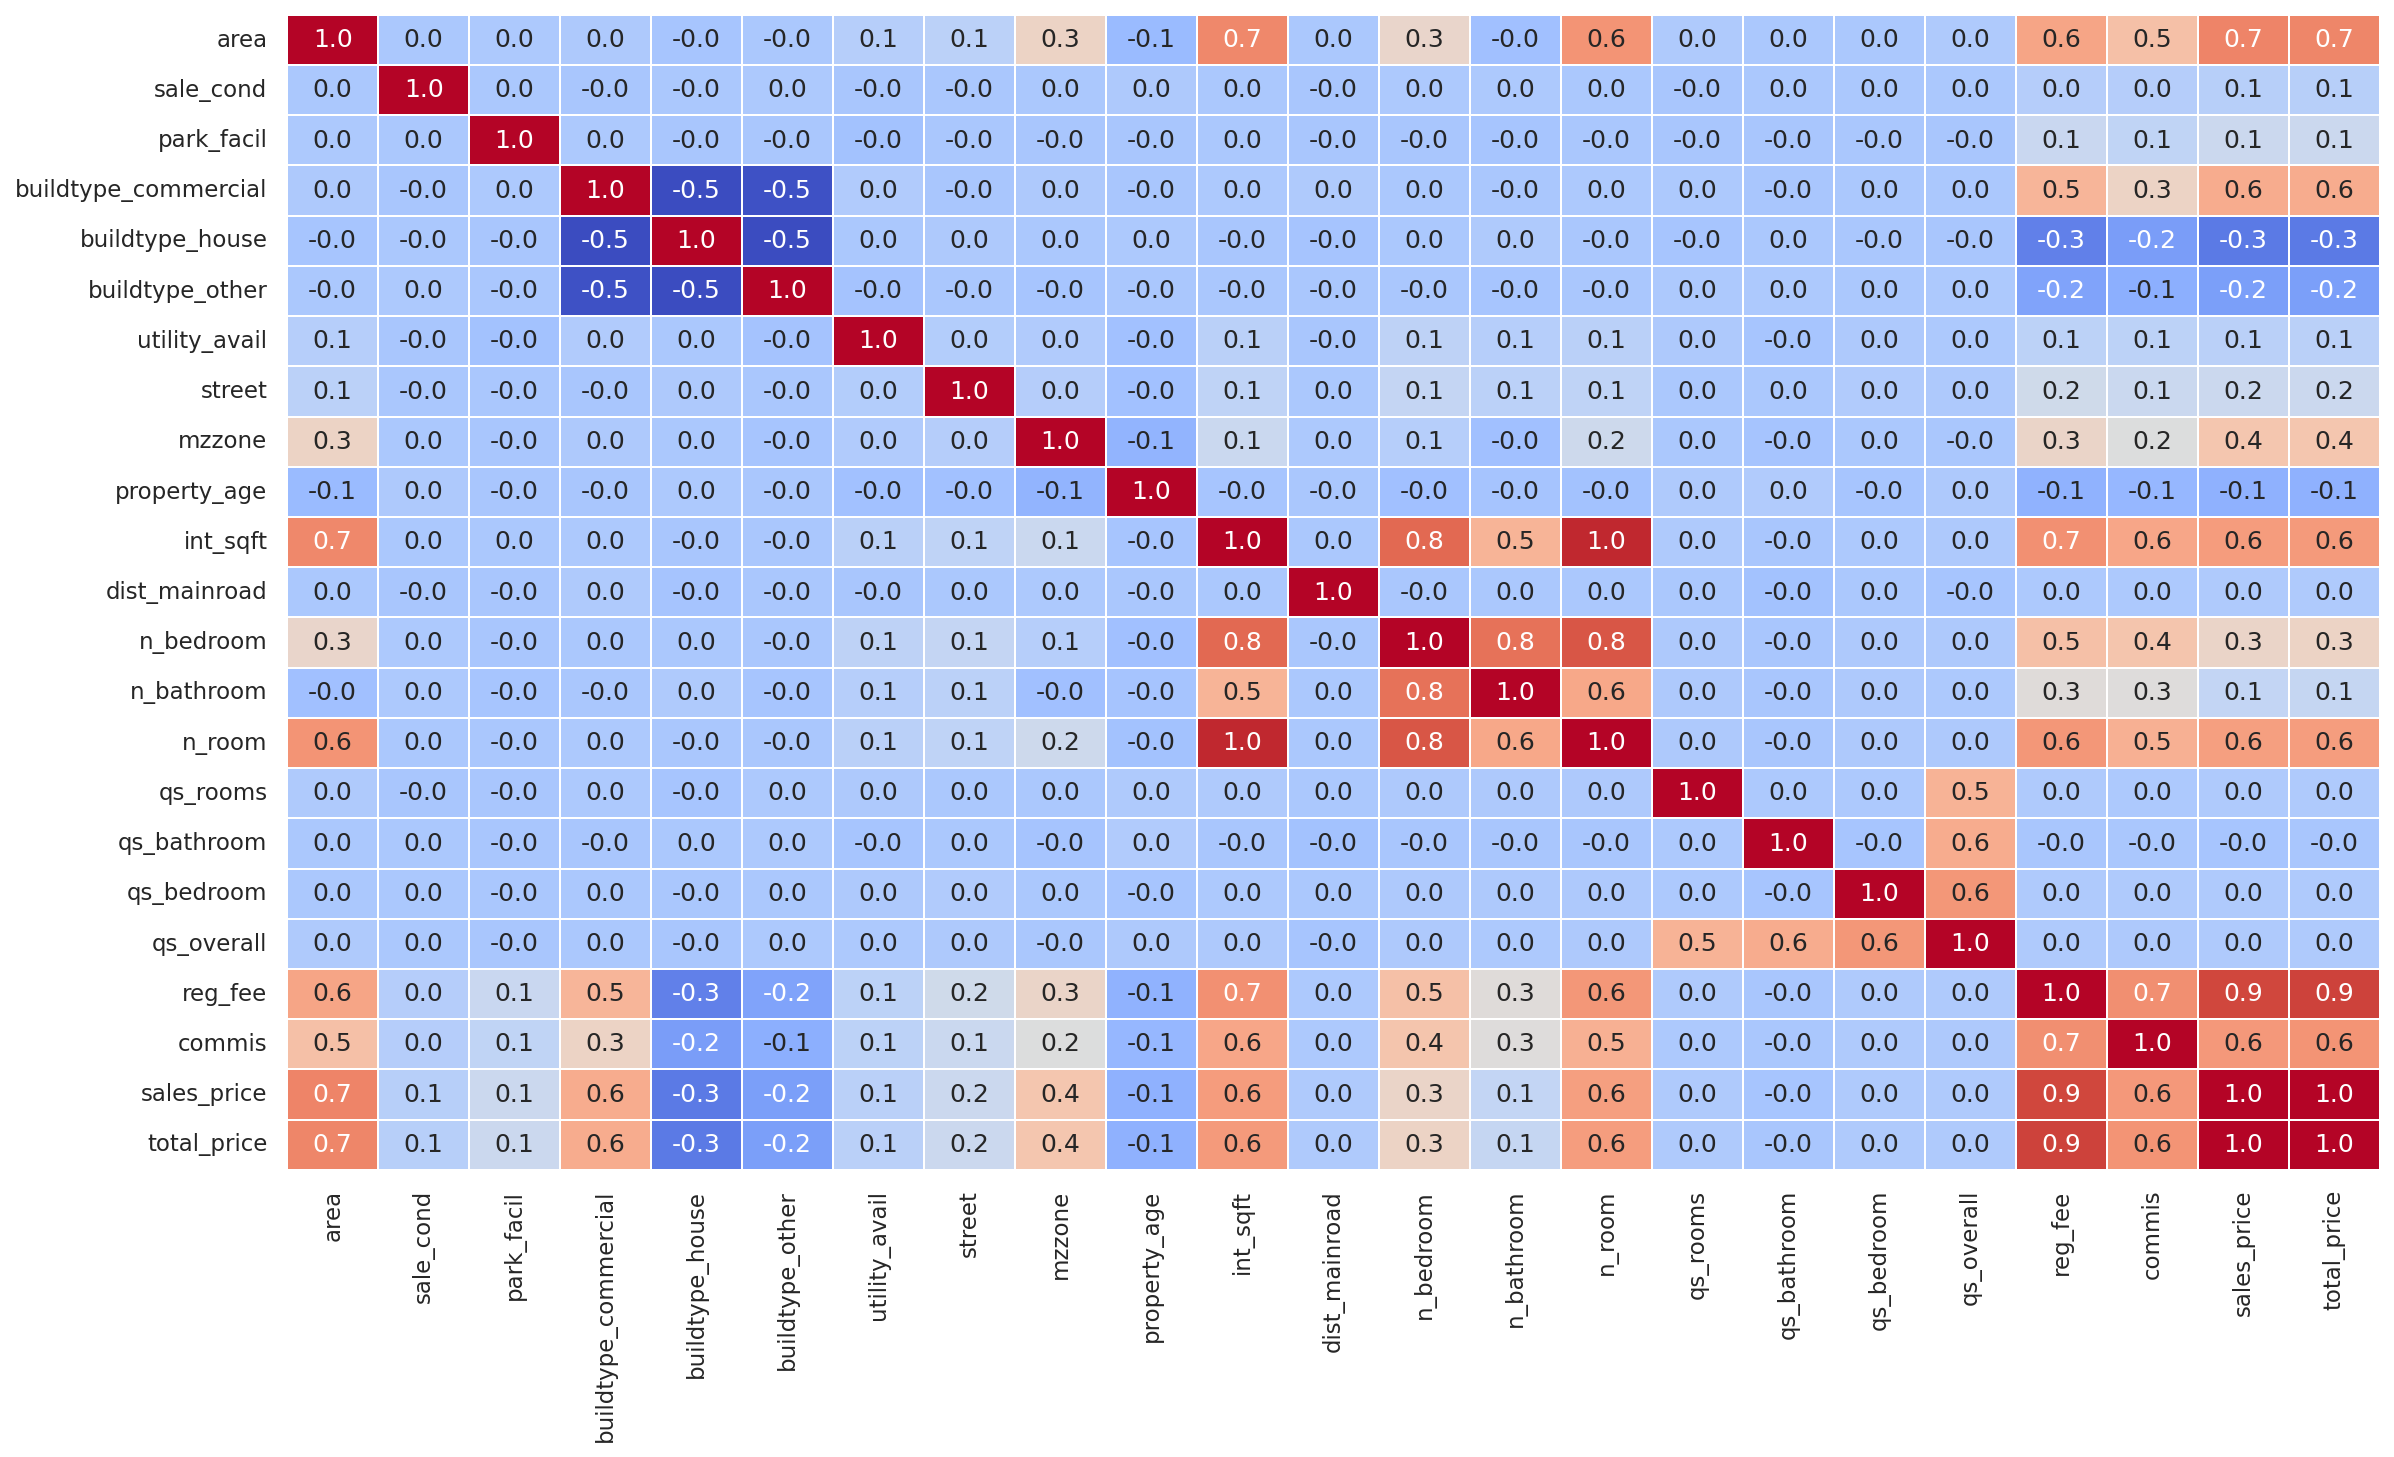

In [ ]:
plt.figure(figsize=(18,10), dpi=150)
sns.heatmap(data.corr(method='pearson'), cbar=False, annot=True, fmt='.1f', linewidth=0.2, cmap='coolwarm');

In [ ]:
data.head()

,area,sale_cond,park_facil,buildtype_commercial,buildtype_house,buildtype_other,utility_avail,street,mzzone,property_age,int_sqft,dist_mainroad,n_bedroom,n_bathroom,n_room,qs_rooms,qs_bathroom,qs_bedroom,qs_overall,reg_fee,commis,sales_price,total_price
0,1,3,1,1,0,0,4,2,1,44,1004,131,1,1,3,4.0,3.9,4.9,4.330,380000,144400,7600000,8124400
1,6,3,0,1,0,0,4,3,4,11,1986,26,2,1,5,4.9,4.2,2.5,3.765,760122,304049,21717770,22781941
2,2,3,1,1,0,0,1,3,5,20,909,70,1,1,3,4.1,3.8,2.2,3.090,421094,92114,13159200,13672408
3,4,2,0,0,0,1,3,2,3,22,1855,14,3,2,5,4.7,3.9,3.6,4.010,356321,77042,9630290,10063653
4,1,3,1,0,0,1,4,3,2,30,1226,84,1,1,3,3.0,2.5,4.1,3.290,237000,74063,7406250,7717313


In [ ]:
# Removing unnecessary features thich has negligible relation with total_price
df = data.copy()
df.drop(['qs_overall', 'dist_mainroad', 'qs_overall','qs_rooms', 'qs_bathroom', 'qs_bedroom', 'reg_fee',	'commis'], axis=1, inplace=True)

In [ ]:
input_cols = ['area', 'sale_cond', 'park_facil', 'buildtype_commercial',	'buildtype_house',
              'buildtype_other', 'utility_avail', 'street', 'mzzone', 'property_age',
              'int_sqft', 'n_bedroom', 'n_bathroom', 'n_room']

target_cols = 'sales_price'
target1_cols = 'total_price'

input = df[input_cols].copy()
target = df[target_cols].copy()
target1 = df[target1_cols].copy()

Splitting the data for training and testing

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(input, target, test_size=0.2, random_state = 7)

Scalling

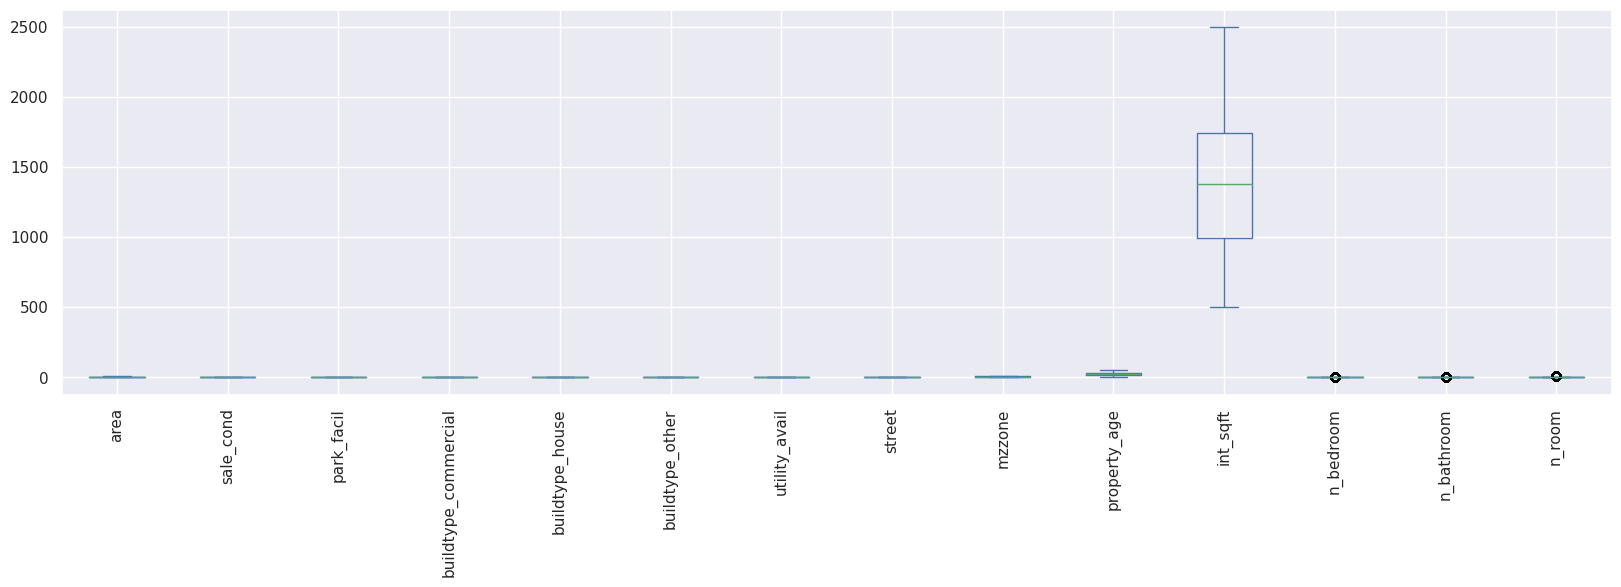

In [ ]:
pd.DataFrame(X_train, columns=X_train.columns).plot.box(figsize=(20,5), rot=90)
plt.show()

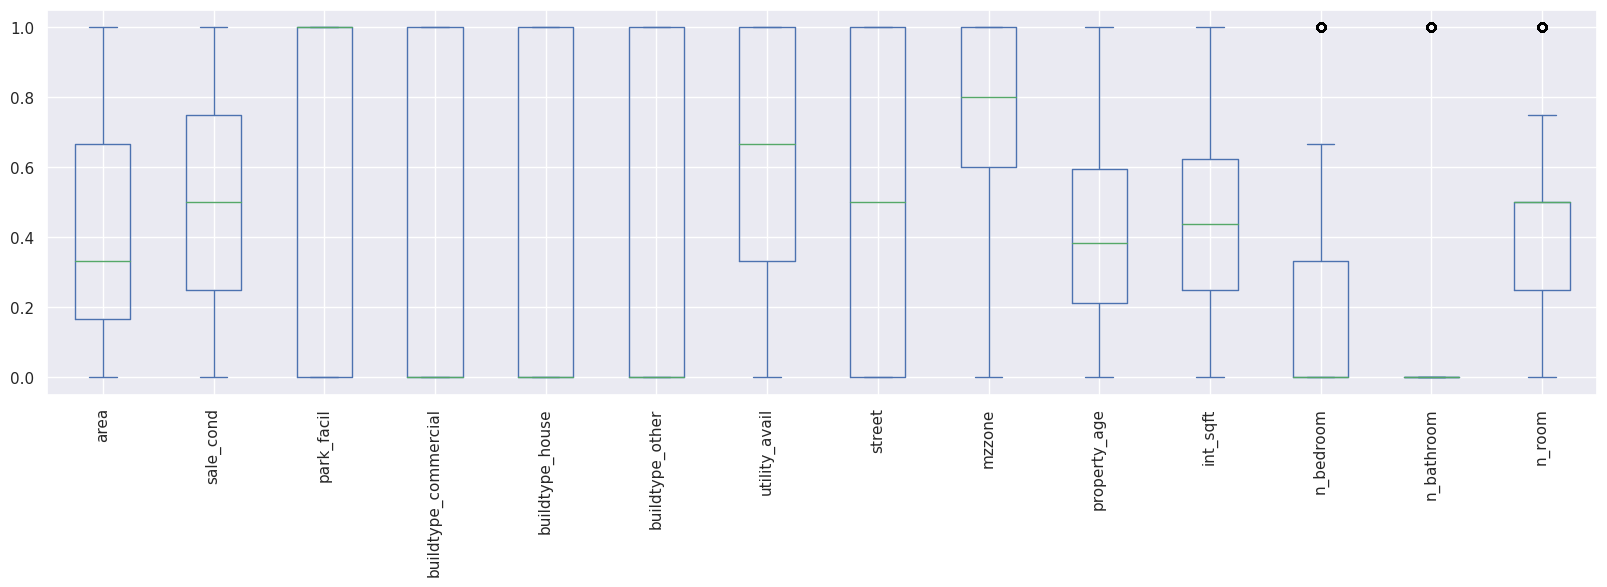

In [ ]:
mm = MinMaxScaler().fit(X_train)
X_train_mm = mm.transform(X_train)
X_train_mm = pd.DataFrame(X_train_mm, columns=X_train.columns)
X_test_mm = mm.transform(X_test)
X_test_mm = pd.DataFrame(X_test_mm, columns=X_test.columns)
X_train_mm.plot.box(figsize=(20,5), rot=90)
plt.show()

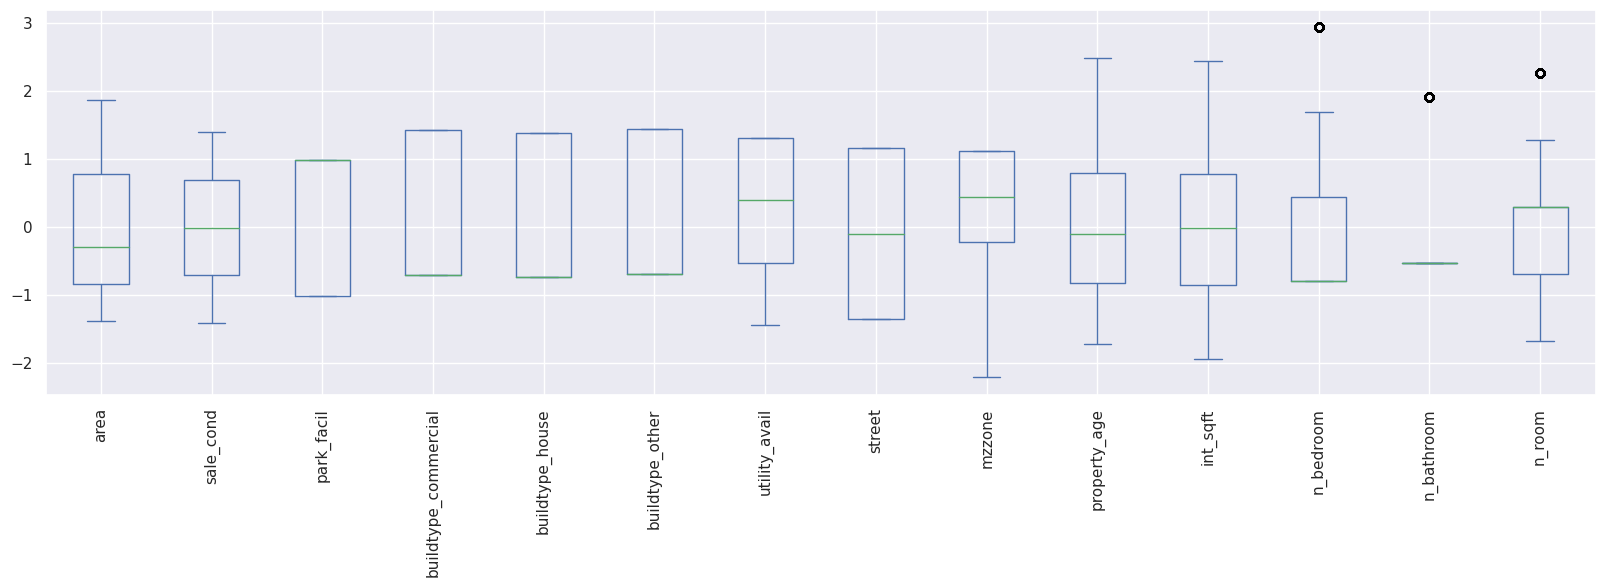

In [ ]:
ss = StandardScaler().fit(X_train)
X_train_ss = ss.transform(X_train)
X_train_ss = pd.DataFrame(X_train_ss, columns=X_train.columns)
X_test_ss = ss.transform(X_test)
X_test_ss = pd.DataFrame(X_test_ss, columns=X_test.columns)
X_train_ss.plot.box(figsize=(20,5), rot=90)
plt.show()

MODEL TESTING
LinearRegression

In [ ]:
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
print('R2- SCORE:', metrics.r2_score(y_test,y_pred))

# lr = LinearRegression()
lr.fit(X_train_ss, y_train)
y_predlrss = lr.predict(X_test_ss)
print('R2- SCORE(Standardscaler):', metrics.r2_score(y_test,y_predlrss))

# lr = LinearRegression()
lr.fit(X_train_mm, y_train)
y_predlrmm = lr.predict(X_test_mm)
print('R2- SCORE(Minmaxscaled):', metrics.r2_score(y_test,y_predlrmm))

R2- SCORE: 0.923424259980204
R2- SCORE(Standardscaler): 0.9235709092298616
R2- SCORE(Minmaxscaled): 0.9234341021512532


KNearestNeigbors

Orange and Blue depict RSME for MinMaxScaler and blue


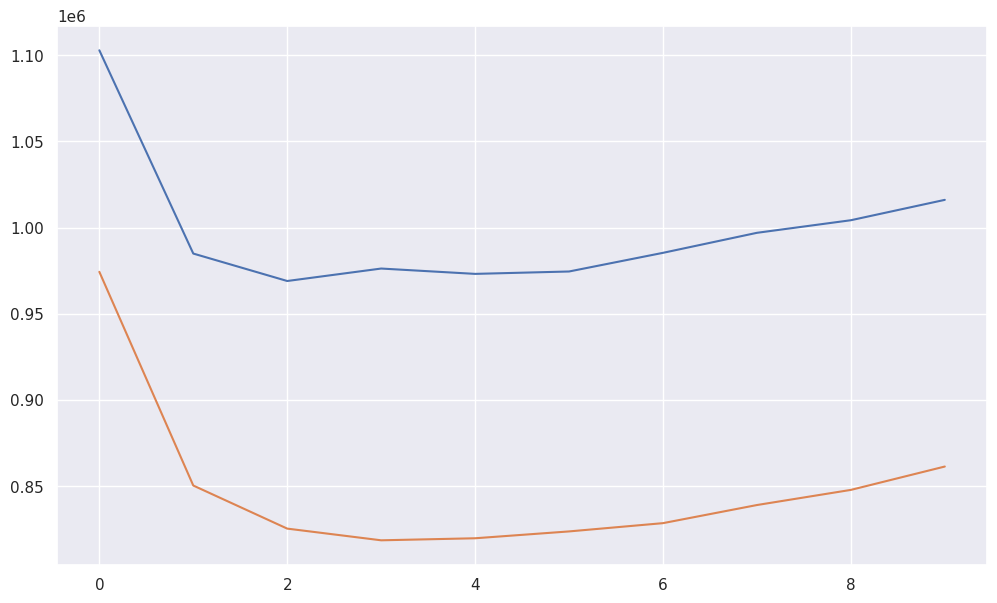

In [ ]:
rmse_val = []
for K in range(10):
    K = K+1
    model = neighbors.KNeighborsRegressor(n_neighbors = K)
    model.fit(X_train_mm, y_train)
    pred=model.predict(X_test_mm)
    error = sqrt(mean_squared_error(y_test,pred))
    rmse_val.append(error)
curve = pd.DataFrame(rmse_val)

rmse_val1 = []
for K in range(10):
    K = K+1
    model = neighbors.KNeighborsRegressor(n_neighbors = K)
    model.fit(X_train_ss, y_train)
    pred=model.predict(X_test_ss)
    error = sqrt(mean_squared_error(y_test,pred))
    rmse_val1.append(error)
curve1 = pd.DataFrame(rmse_val1)

print('Orange and Blue depict RSME for MinMaxScaler and blue')
plt.figure(figsize=(12,7))
plt.plot(curve)
plt.plot(curve1)
plt.show()

In [ ]:
knn = KNeighborsRegressor(n_neighbors=100)
knn.fit(X_train, y_train)
y_predknn = knn.predict(X_test)
print('R2- SCORE:', metrics.r2_score(y_test,y_predknn))

knn = KNeighborsRegressor(n_neighbors=3)
knn.fit(X_train_mm, y_train)
y_predknn_mm = knn.predict(X_test_mm)
print('R2- SCORE(Minmaxscaled):', metrics.r2_score(y_test,y_predknn_mm))

knn = KNeighborsRegressor(n_neighbors=4)
knn.fit(X_train_ss, y_train)
y_predknn_ss = knn.predict(X_test_ss)
print('R2- SCORE(Standardscaler):', metrics.r2_score(y_test,y_predknn_ss))

R2- SCORE: 0.43309895459186276
R2- SCORE(Minmaxscaled): 0.9338292932490762
R2- SCORE(Standardscaler): 0.9527770963012473


DecisionTree

In [ ]:
dt = DecisionTreeRegressor()
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)
print('R2- SCORE:', metrics.r2_score(y_test,y_pred_dt))

dt.fit(X_train_mm, y_train)
y_pred_dtmm = dt.predict(X_test_mm)
print('R2- SCORE(Minmaxscaled):', metrics.r2_score(y_test,y_pred_dtmm))

dt.fit(X_train_ss, y_train)
y_pred_dtss = dt.predict(X_test_ss)
print('R2- SCORE(Standardscaler):', metrics.r2_score(y_test,y_pred_dtss))

R2- SCORE: 0.9753048041545311
R2- SCORE(Minmaxscaled): 0.9751749298359393
R2- SCORE(Standardscaler): 0.9750339556661666


Ensamble Learning

Voting Regressor

In [ ]:
dt = DecisionTreeRegressor()
knn = KNeighborsRegressor(n_neighbors=100)
lr = LinearRegression()
rf = RandomForestRegressor(n_estimators= 100, max_depth = 15, max_features='sqrt')
xg = xgb.XGBRegressor(learning_rate = .7, n_estimators=100, verbosity = 0)
gbr = GradientBoostingRegressor(learning_rate=.5)
etr = ExtraTreesRegressor(n_estimators=100, random_state=0).fit(X_train, y_train)

vr = VotingRegressor([('dt', dt), ('knn', knn), ('lr', lr), ('rf', rf), ('xg', xg), ('gbr', gbr), ('etr', etr)])

vr.fit(X_train, y_train);
y_pred_vr = vr.predict(X_test)
print('R2- SCORE:', metrics.r2_score(y_test,y_pred_vr))

vr.fit(X_train_ss, y_train);
y_pred_vrss = vr.predict(X_test_ss)
print('R2- SCORE(Standardscaler):', metrics.r2_score(y_test,y_pred_vrss))

vr.fit(X_train_mm, y_train);
y_pred_vrmm = vr.predict(X_test_mm)
print('R2- SCORE(MinMaxScaler):', metrics.r2_score(y_test,y_pred_vr))

R2- SCORE: 0.9789001957528317
R2- SCORE(Standardscaler): 0.9896016089335163
R2- SCORE(MinMaxScaler): 0.9789001957528317


Random Forest

In [ ]:
rf = RandomForestRegressor(n_estimators= 100, max_depth = 15, max_features='sqrt')
rf.fit(X_train, y_train);
y_pred_rf = rf.predict(X_test)
print('R2- SCORE:', metrics.r2_score(y_test,y_pred_rf))

rf.fit(X_train_mm, y_train);
y_pred_rfmm = rf.predict(X_test_mm)
print('R2- SCORE(minmaxscaled):', metrics.r2_score(y_test,y_pred_rfmm))

rf.fit(X_train_ss, y_train);
y_pred_rfss = rf.predict(X_test_ss)
print('R2- SCORE(Standardscaler):', metrics.r2_score(y_test,y_pred_rfss))

R2- SCORE: 0.9872828472087586
R2- SCORE(minmaxscaled): 0.9872349783599287
R2- SCORE(Standardscaler): 0.9869621998500991


XGBoost

In [ ]:
xg = xgb.XGBRegressor(learning_rate = .7, n_estimators=100, verbosity = 0)
xg.fit(X_train, y_train)
y_pred_gbr = xg.predict(X_test)
print('R2- SCORE:', metrics.r2_score(y_test,y_pred_gbr))

xg.fit(X_train_mm, y_train)
y_pred_gbrmm = xg.predict(X_test_mm)
print('R2- SCORE(MinMaxScaler):', metrics.r2_score(y_test,y_pred_gbrmm))

xg.fit(X_train_ss, y_train)
y_pred_gbrss = xg.predict(X_test_ss)
print('R2- SCORE(Standardscaler):', metrics.r2_score(y_test,y_pred_gbrss))

R2- SCORE: 0.9928826290720715
R2- SCORE(MinMaxScaler): 0.9928826290720715
R2- SCORE(Standardscaler): 0.9928826290720715
